<a href="https://colab.research.google.com/github/ellenaranxa6/TCCV5/blob/main/logica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# BLOCO 01 — AMBIENTE (Google Colab): instalação e montagem do Drive
# Objetivo:
#   - Instalar dependências (somente no Colab)
#   - Montar o Google Drive para acessar arquivos do projeto OpenDSS
# Observação: Em execução local (VSCode/Windows), este bloco NÃO é necessário.

# 1) Instalação das bibliotecas (somente no Colab)
!pip install -q py-dss-interface opendssdirect.py tabulate pandas
# 2) Montagem do Google Drive (somente no Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import math
from typing import Dict, List, Set, Tuple, Optional
from itertools import product

import opendssdirect as dss
import networkx as nx
import matplotlib.pyplot as plt

# =========================================================
# 0) CONFIGURAÇÕES DO SISTEMA (IEEE123) E PARÂMETROS
# =========================================================

BASE_DIR = "/content/drive/MyDrive/Engenharia/TCCEllen/123BusV3"
RUN_DSS = os.path.join(BASE_DIR, "Run_IEEE123Bus.DSS")
BUSCOORDS = os.path.join(BASE_DIR, "BusCoords.dat")
#CHAVES NF e NA
NF_LIST = ["line.sw1", "line.sw2", "line.sw3", "line.sw4", "line.sw5", "line.sw6"]
NA_LIST = ["line.sw7", "line.l108"]
NA_PRIORITY = ["line.sw7", "line.l108"]
#FONTES
BUS_FONTE_A = "150"
BUS_FONTE_B = "300"

DEBUG = True

# (R1) MODO DE ISOLAMENTO POR CORRENTE
MAINT_ZERO_EXACT = True
MAINT_I_THRESH_A = 0.0 #PARA CONSIDERAR O VÃO DESLIGADO, I=0

CURRENT_LIMIT_ENABLED = True
USE_EMERGENCY_RATING = False
IGNORE_IF_RATING_ZERO = True

#REFERENCIAS DE TENSAO NODAL
VOLT_QUALITY_ENABLED = True
VMIN_PU = 0.95
VMAX_PU = 1.05
VPU_ZERO_EPS = 1e-3

# =========================================================
# 1) DSS — Funções-base de estado e normalização
# =========================================================

def _as_line_elem(x: str) -> str:
    x = x.strip().lower()
    return x if x.startswith("line.") else f"line.{x}"

def compile_circuit() -> None:
    dss.Text.Command("Clear")
    dss.Text.Command(f"Compile ({RUN_DSS})")

    for nf in NF_LIST:
        dss.Text.Command(f"close {nf}")
    for na in NA_LIST:
        dss.Text.Command(f"open {na}")

    dss.Solution.Solve()

def get_bus_name_without_node(bus_full: str) -> str:
    if not bus_full:
        return ""
    return bus_full.split(".")[0].lower()

# =========================================================
# 2) Utilitários elétricos/topológicos
# =========================================================

def get_energized_buses(threshold_volts: float = 100.0) -> Set[str]:
    energized: Set[str] = set()
    for bus_name in dss.Circuit.AllBusNames():
        dss.Circuit.SetActiveBus(bus_name)
        vals = dss.Bus.VMagAngle()
        mags = vals[0::2]
        if mags and any(v > threshold_volts for v in mags):
            energized.add(bus_name.lower())
    return energized

def is_line_fully_open(elem_name: str) -> bool:
    try:
        dss.Circuit.SetActiveElement(elem_name)
    except Exception:
        return False

    n_terms = int(dss.CktElement.NumTerminals())
    n_phases = int(dss.CktElement.NumPhases())

    for t in range(1, n_terms + 1):
        for p in range(1, n_phases + 1):
            try:
                if not dss.CktElement.IsOpen(t, p):
                    return False
            except Exception:
                return False
    return True

def build_graph_from_dss() -> nx.Graph:
    G = nx.Graph()
    for lname in dss.Lines.AllNames():
        elem = f"line.{lname.lower()}"
        if is_line_fully_open(elem):
            continue
        dss.Lines.Name(lname)
        b1 = get_bus_name_without_node(dss.Lines.Bus1())
        b2 = get_bus_name_without_node(dss.Lines.Bus2())
        if b1 and b2:
            G.add_edge(b1, b2, element=elem)
    return G

def has_parallel_between_sources(G: nx.Graph) -> bool:
    a = BUS_FONTE_A.lower()
    b = BUS_FONTE_B.lower()
    if a not in G.nodes or b not in G.nodes:
        return False
    return nx.has_path(G, a, b)

#GEORREFERENCIAMENTO DA REDE
def load_buscoords() -> Dict[str, Tuple[float, float]]:
    coords: Dict[str, Tuple[float, float]] = {}
    if not os.path.exists(BUSCOORDS):
        print(f"BusCoords.dat não encontrado: {BUSCOORDS}")
        return coords

    with open(BUSCOORDS, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("!"):
                continue
            parts = line.split()
            if len(parts) < 3:
                continue
            bus = parts[0].lower()
            try:
                x = float(parts[1]); y = float(parts[2])
            except ValueError:
                continue
            coords[bus] = (x, y)
    return coords

#VERIFICAR AS BARRAS/TERMINAIS DA LINHA INFORMADA
def get_line_terminals(line_elem: str) -> Optional[Tuple[str, str]]:
    elem = _as_line_elem(line_elem)
    try:
        dss.Circuit.SetActiveElement(elem)
        buses = dss.CktElement.BusNames()
        if len(buses) < 2:
            return None
        b1 = get_bus_name_without_node(buses[0])
        b2 = get_bus_name_without_node(buses[1])
        return b1, b2
    except Exception:
        return None

# =========================================================
# 3) Cargas por barra
# =========================================================

def get_bus_load_kw() -> Dict[str, float]:
    compile_circuit()
    bus_load: Dict[str, float] = {}

    for name in dss.Loads.AllNames():
        dss.Loads.Name(name)
        bus_names = dss.CktElement.BusNames()
        if not bus_names:
            continue
        bus = get_bus_name_without_node(bus_names[0])
        kw = float(dss.Loads.kW())
        bus_load[bus] = bus_load.get(bus, 0.0) + kw
    return bus_load

# =========================================================
# 4) Correntes
# =========================================================

def is_switch_line(elem: str) -> bool:
    return elem.lower().strip().startswith("line.sw")

def get_element_max_current(elem_name: str) -> float:
    try:
        dss.Circuit.SetActiveElement(elem_name)
    except Exception:
        return 0.0
    magsang = dss.CktElement.CurrentsMagAng()
    mags = magsang[0::2]
    return float(max(mags)) if mags else 0.0

def get_line_norm_emerg_amps(line_elem: str) -> Tuple[float, float]:
    lname = line_elem.lower().replace("line.", "")
    try:
        dss.Lines.Name(lname)
        return float(dss.Lines.NormAmps()), float(dss.Lines.EmergAmps())
    except Exception:
        return 0.0, 0.0

def get_line_loading_violations(
    use_emergency: bool = False,
    i_threshold_energized: float = 1.0,
    ignore_if_rating_zero: bool = True,
) -> Dict[str, Dict]:

    viol: Dict[str, Dict] = {}

    for lname in dss.Lines.AllNames():
        elem = f"line.{lname.lower()}"

        if is_switch_line(elem):
            continue
        if is_line_fully_open(elem):
            continue

        imax = get_element_max_current(elem)
        if imax <= i_threshold_energized:
            continue

        norm, emerg = get_line_norm_emerg_amps(elem)
        limit = emerg if use_emergency else norm

        if limit <= 0.0 and ignore_if_rating_zero:
            continue

        if limit > 0.0 and imax > limit:
            viol[elem] = {
                "Imax_A": float(imax),
                "limit_A": float(limit),
                "ratio": float(imax / limit),
                "NormAmps": float(norm),
                "EmergAmps": float(emerg),
            }

    return viol

def compare_violations_base_vs_after(
    base_viol: Dict[str, Dict],
    after_viol: Dict[str, Dict],
    eps_ratio: float = 0.00,
) -> Tuple[bool, Optional[Dict]]:

    worst = None

    for elem, a in after_viol.items():
        if elem not in base_viol:
            cand = {"reason": "nova_violacao", "element": elem, **a}
            if (worst is None) or (cand["ratio"] > worst["ratio"]):
                worst = cand

    for elem, a in after_viol.items():
        if elem in base_viol:
            rb = float(base_viol[elem]["ratio"])
            ra = float(a["ratio"])
            if ra > rb + eps_ratio:
                cand = {"reason": "piora_violacao", "element": elem, **a, "ratio_base": rb}
                if (worst is None) or (cand["ratio"] > worst["ratio"]):
                    worst = cand

    return (worst is not None), worst

# =========================================================
# 5) Restrição R1 — Manutenção por corrente (ZERO EXATO / LIMIAR)
# =========================================================

def maint_line_is_deenergized_by_current(line_elem: str) -> Tuple[bool, float]:
    elem = _as_line_elem(line_elem)
    imax = float(get_element_max_current(elem))

    if MAINT_ZERO_EXACT:
        ok = (imax == 0.0)
    else:
        ok = (imax < float(MAINT_I_THRESH_A))

    return ok, imax

# =========================================================
# 6) Qualidade de tensão (não bloqueante)
# =========================================================

def get_voltage_violations_pu(
    vmin_pu: float = 0.95,
    vmax_pu: float = 1.05,
    ignore_zeros: bool = True,
    zero_eps: float = 1e-3,
) -> Dict[str, Dict]:

    viol: Dict[str, Dict] = {}
    for bus in dss.Circuit.AllBusNames():
        dss.Circuit.SetActiveBus(bus)
        vals = dss.Bus.puVmagAngle()
        mags = vals[0::2]
        if not mags:
            continue

        mags_f = []
        for v in mags:
            if ignore_zeros and v <= zero_eps:
                continue
            mags_f.append(v)

        if not mags_f:
            continue

        vmin_bus = float(min(mags_f))
        vmax_bus = float(max(mags_f))

        if (vmin_bus < vmin_pu) or (vmax_bus > vmax_pu):
            viol[bus.lower()] = {"vmin_pu_bus": vmin_bus, "vmax_pu_bus": vmax_bus}

    return viol

def summarize_voltage_violations(viol: Dict[str, Dict]) -> Dict:
    if not viol:
        return {"n_viol": 0, "worst_bus": None, "worst_vmin": None, "worst_vmax": None}

    worst_bus, info = min(viol.items(), key=lambda kv: kv[1]["vmin_pu_bus"])
    return {
        "n_viol": int(len(viol)),
        "worst_bus": worst_bus,
        "worst_vmin": float(info["vmin_pu_bus"]),
        "worst_vmax": float(info["vmax_pu_bus"]),
    }

# =========================================================
# 7) Entrada do usuário (linhas) e validação
# =========================================================

def get_lines_from_user_input(line_names: List[str]) -> List[str]:
    compile_circuit()
    valid: List[str] = []

    for lname in line_names:
        elem = _as_line_elem(lname)
        try:
            dss.Circuit.SetActiveElement(elem)
            valid.append(elem)
        except Exception:
            print(f"Linha não encontrada/ativável: {elem}")

    seen = set()
    out: List[str] = []
    for e in valid:
        if e in seen:
            continue
        seen.add(e)
        out.append(e)
    return out

# =========================================================
# 8) Pré-cálculo: efeito de abrir cada NF isoladamente
# =========================================================

def precompute_nf_base_islands(
    bus_load_kw: Dict[str, float],
    maint_lines: List[str],
) -> Dict[str, Dict]:

    results: Dict[str, Dict] = {}

    compile_circuit()
    energized_base = get_energized_buses()
    maint_elems = [_as_line_elem(x) for x in maint_lines]

    for nf in NF_LIST:
        compile_circuit()
        dss.Text.Command(f"open {nf}")
        dss.Solution.Solve()

        energized_after = get_energized_buses()
        buses_off = energized_base - energized_after
        kw_off = sum(bus_load_kw.get(b, 0.0) for b in buses_off)

        isolates_lines = set()
        for ml in maint_elems:
            ok, _imax = maint_line_is_deenergized_by_current(ml)
            if ok:
                isolates_lines.add(ml)

        results[nf] = {
            "buses_off": buses_off,
            "kw_off": float(kw_off),
            "isolates_lines": isolates_lines,
        }

    return results

# =========================================================
# 9) Seleção de NFs e redundância
# =========================================================

def nf_isolates_maint_line(nf: str, maint_line: str, nf_base_data: Dict[str, Dict]) -> bool:
    ml = _as_line_elem(maint_line)
    return ml in nf_base_data[nf]["isolates_lines"]

def candidates_for_maint_line(maint_line: str, nf_base_data: Dict[str, Dict]) -> List[str]:
    return [nf for nf in NF_LIST if nf_isolates_maint_line(nf, maint_line, nf_base_data)]

def reduce_nf_set_by_redundancy_lines(
    maint_lines: List[str],
    line_to_nf: Dict[str, str],
    nf_base_data: Dict[str, Dict],
) -> Set[str]:

    nf_set = set(line_to_nf.values())

    def line_covered_by_set(ml: str, s: Set[str]) -> bool:
        ml = _as_line_elem(ml)
        return any(ml in nf_base_data[nf]["isolates_lines"] for nf in s)

    removable_order = sorted(list(nf_set), key=lambda nf: nf_base_data[nf]["kw_off"], reverse=True)

    for nf_try_remove in removable_order:
        cand_set = set(nf_set)
        cand_set.remove(nf_try_remove)

        ok = True
        for ml in maint_lines:
            if not line_covered_by_set(ml, cand_set):
                ok = False
                break

        if ok:
            nf_set = cand_set

    return nf_set

# =========================================================
# 10) Avaliação de cenário (restrições + métricas)
# =========================================================

def evaluate_scenario(
    nf_isol_set: Set[str],
    bus_load_kw: Dict[str, float],
    maint_lines: List[str],
    base_viol: Dict[str, Dict],
    na: Optional[str] = None,
    nf_block: Optional[str] = None,
    enable_current_limit: bool = True,
    use_emergency_rating: bool = False,
    debug: bool = False,
) -> Optional[Dict]:

    compile_circuit()

    for nf in nf_isol_set:
        dss.Text.Command(f"open {nf}")

    if nf_block is not None and nf_block not in nf_isol_set:
        dss.Text.Command(f"open {nf_block}")

    if na is not None:
        dss.Text.Command(f"close {na}")

    dss.Solution.Solve()

    # (R2) paralelismo
    G = build_graph_from_dss()
    if has_parallel_between_sources(G):
        if debug:
            print(f"REJEITADO (paralelismo): NF={sorted(nf_isol_set)} NA={na} BLK={nf_block}")
        return None

    # (R1) manutenção
    for ml in maint_lines:
        ok, imax = maint_line_is_deenergized_by_current(ml)
        if not ok:
            if debug:
                modo = "ZERO_EXATO" if MAINT_ZERO_EXACT else f"LIMIAR<{MAINT_I_THRESH_A}A"
                print(f"REJEITADO (manutenção - {modo}): {ml} Imax={imax:.6f}A | "
                      f"NF={sorted(nf_isol_set)} NA={na} BLK={nf_block}")
            return None

    # (R3) incremental por rating
    if enable_current_limit:
        after_viol = get_line_loading_violations(
            use_emergency=use_emergency_rating,
            i_threshold_energized=1.0,
            ignore_if_rating_zero=IGNORE_IF_RATING_ZERO
        )

        reject, detail = compare_violations_base_vs_after(
            base_viol=base_viol,
            after_viol=after_viol,
            eps_ratio=0.00
        )

        if reject:
            if debug and detail is not None:
                if detail["reason"] == "nova_violacao":
                    print(f"REJEITADO (nova sobrecorrente): {detail['element']} "
                          f"Imax={detail['Imax_A']:.2f}A lim={detail['limit_A']:.2f}A ratio={detail['ratio']:.2f} | "
                          f"NF={sorted(nf_isol_set)} NA={na} BLK={nf_block}")
                else:
                    print(f"REJEITADO (piora sobrecorrente): {detail['element']} "
                          f"ratio_base={detail['ratio_base']:.2f} -> ratio_after={detail['ratio']:.2f} | "
                          f"NF={sorted(nf_isol_set)} NA={na} BLK={nf_block}")
            return None

    # Indicador tensão (não bloqueante)
    vsum = {"n_viol": 0, "worst_bus": None, "worst_vmin": None, "worst_vmax": None}
    if VOLT_QUALITY_ENABLED:
        vviol = get_voltage_violations_pu(
            vmin_pu=VMIN_PU,
            vmax_pu=VMAX_PU,
            ignore_zeros=True,
            zero_eps=VPU_ZERO_EPS
        )
        vsum = summarize_voltage_violations(vviol)
        if debug and vsum["n_viol"] > 0:
            print(
                f"AVISO (tensão): {vsum['n_viol']} barras energizadas fora de "
                f"[{VMIN_PU:.2f}, {VMAX_PU:.2f}] pu | pior={vsum['worst_bus']} "
                f"vmin={vsum['worst_vmin']:.4f} pu | NF={sorted(nf_isol_set)} NA={na} BLK={nf_block}"
            )

    energized = get_energized_buses()
    all_buses = {b.lower() for b in dss.Circuit.AllBusNames()}
    buses_off = all_buses - energized
    kw_off = sum(bus_load_kw.get(b, 0.0) for b in buses_off)

    n_manobras = len(nf_isol_set)
    if na is not None:
        n_manobras += 1
    if nf_block is not None and nf_block not in nf_isol_set:
        n_manobras += 1

    return {
        "nf_isol": sorted(list(nf_isol_set)),
        "na": na,
        "nf_block": nf_block,
        "buses_off": buses_off,
        "kw_off": float(kw_off),
        "n_manobras": int(n_manobras),
        "n_v_viol": vsum["n_viol"],
        "worst_v_bus": vsum["worst_bus"],
        "worst_vmin_pu": vsum["worst_vmin"],
        "worst_vmax_pu": vsum["worst_vmax"],
    }

# =========================================================
# 11) Busca de opções (até 3)
# =========================================================

def find_options_for_lines(
    maint_lines: List[str],
    bus_load_kw: Dict[str, float],
    nf_base_data: Dict[str, Dict],
    base_viol: Dict[str, Dict],
    max_options: int = 3,
    debug: bool = False,
    top_k_nf_per_line: int = 3,
) -> List[Dict]:

    if not maint_lines:
        return []

    # 1) candidatas por linha (ordenadas por menor kw_off no pré-cálculo)
    cand_list_per_line: List[List[str]] = []
    for ml in maint_lines:
        cands = candidates_for_maint_line(ml, nf_base_data)
        if not cands:
            if debug:
                print(f"DEBUG: Sem NF candidata para {ml}")
            return []

        cands = sorted(cands, key=lambda nf: nf_base_data[nf]["kw_off"])
        cand_list_per_line.append(cands[:top_k_nf_per_line])

        if debug:
            print(f"DEBUG: TOP-{top_k_nf_per_line} NFs para {ml}: {cands[:top_k_nf_per_line]}")

    # 2) combinações de NFs (produto)
    nf_sets_to_test: List[Set[str]] = []
    for combo in product(*cand_list_per_line):
        line_to_nf = {_as_line_elem(ml): nf for ml, nf in zip(maint_lines, combo)}
        nf_set = reduce_nf_set_by_redundancy_lines(maint_lines, line_to_nf, nf_base_data)
        nf_sets_to_test.append(nf_set)

    # dedup de nf_set
    uniq_nf_sets: List[Set[str]] = []
    seen_nf = set()
    for s in nf_sets_to_test:
        key = tuple(sorted(s))
        if key in seen_nf:
            continue
        seen_nf.add(key)
        uniq_nf_sets.append(s)

    options: List[Dict] = []

    # 3) avalia cenários
    for nf_isol_set in uniq_nf_sets:

        # BASE (para esse nf_set)
        base = evaluate_scenario(
            nf_isol_set=nf_isol_set,
            bus_load_kw=bus_load_kw,
            maint_lines=maint_lines,
            base_viol=base_viol,
            na=None,
            nf_block=None,
            enable_current_limit=CURRENT_LIMIT_ENABLED,
            use_emergency_rating=USE_EMERGENCY_RATING,
            debug=debug
        )
        if base is None:
            continue

        kw_base = base["kw_off"]
        base["kw_base"] = kw_base
        base["tipo"] = "BASE (NF testada)"
        options.append(base)

        # NA(s) e NA+BLK (somente se melhorar kw_base)
        for na in NA_PRIORITY:

            scen_na = evaluate_scenario(
                nf_isol_set=nf_isol_set,
                bus_load_kw=bus_load_kw,
                maint_lines=maint_lines,
                base_viol=base_viol,
                na=na,
                nf_block=None,
                enable_current_limit=CURRENT_LIMIT_ENABLED,
                use_emergency_rating=USE_EMERGENCY_RATING,
                debug=debug
            )

            if scen_na is not None and scen_na["kw_off"] < kw_base:
                scen_na["kw_base"] = kw_base
                scen_na["tipo"] = "NA sem bloqueio"
                options.append(scen_na)
                continue

            for nf_block in NF_LIST:
                if nf_block in nf_isol_set:
                    continue

                scen_blk = evaluate_scenario(
                    nf_isol_set=nf_isol_set,
                    bus_load_kw=bus_load_kw,
                    maint_lines=maint_lines,
                    base_viol=base_viol,
                    na=na,
                    nf_block=nf_block,
                    enable_current_limit=CURRENT_LIMIT_ENABLED,
                    use_emergency_rating=USE_EMERGENCY_RATING,
                    debug=debug
                )

                if scen_blk is None:
                    continue

                if scen_blk["kw_off"] < kw_base:
                    scen_blk["kw_base"] = kw_base
                    scen_blk["tipo"] = "NA + bloqueio"
                    options.append(scen_blk)

    if not options:
        return []

    # 4) ordena e dedup final (retorna até 3)
    options_sorted = sorted(options, key=lambda o: (o["kw_off"], o["n_manobras"], o.get("n_v_viol", 0)))

    uniq: List[Dict] = []
    seen = set()
    for opt in options_sorted:
        key = (tuple(opt["nf_isol"]), opt.get("na"), opt.get("nf_block"))
        if key in seen:
            continue
        seen.add(key)
        uniq.append(opt)
        if len(uniq) >= max_options:
            break

    return uniq

# =========================================================
# 12) Plot
# =========================================================

def get_bus_voltages_pu_for_plot() -> Dict[str, float]:
    vbus: Dict[str, float] = {}
    for bus in dss.Circuit.AllBusNames():
        dss.Circuit.SetActiveBus(bus)
        vals = dss.Bus.VMagAngle()
        mags = vals[0::2]
        if not mags:
            vbus[bus.lower()] = 0.0
            continue
        vmax = max(mags)
        kvbase_ll = dss.Bus.kVBase()
        if kvbase_ll and kvbase_ll > 0:
            vbase_ln = (kvbase_ll * 1000) / math.sqrt(3)
            vpu = vmax / vbase_ln
        else:
            vpu = 0.0
        vbus[bus.lower()] = vpu
    return vbus

def plot_option(option: Dict, maint_lines: List[str], title: str = "Opção") -> None:
    compile_circuit()

    for nf in option["nf_isol"]:
        dss.Text.Command(f"open {nf}")
    if option.get("nf_block"):
        dss.Text.Command(f"open {option['nf_block']}")
    if option.get("na"):
        dss.Text.Command(f"close {option['na']}")

    dss.Solution.Solve()

    G = build_graph_from_dss()
    coords = load_buscoords()
    pos = {n: coords.get(n, (0, 0)) for n in G.nodes()}

    vbus = get_bus_voltages_pu_for_plot()
    energized = {b for b, v in vbus.items() if v >= 0.05}
    desligadas = set(G.nodes()) - energized

    maint_nodes = set()
    for ml in maint_lines:
        terms = get_line_terminals(ml)
        if terms:
            maint_nodes.update(terms)

    plt.figure(figsize=(12, 8))

    highlight_elems = set(option["nf_isol"])
    if option.get("na"):
        highlight_elems.add(option["na"])
    if option.get("nf_block"):
        highlight_elems.add(option["nf_block"])

    edge_colors = []
    for _, _, data in G.edges(data=True):
        elem = data.get("element", "")
        edge_colors.append("cyan" if elem in highlight_elems else "green")

    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)

    node_colors = []
    for n in G.nodes():
        if n in maint_nodes:
            node_colors.append("yellow")
        elif n in desligadas:
            node_colors.append("red")
        else:
            node_colors.append("green")

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=70)
    nx.draw_networkx_labels(G, pos, font_size=6)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# =========================================================
# 13) Main — execução
# =========================================================

def main() -> None:
    print("Manobras IEEE-123 Bus\n")

    linhas_str = input("\nDigite as LINHAS (ex.: L52,L80,L100): ").strip()
    raw_lines = [s.strip() for s in linhas_str.split(",") if s.strip()]
    maint_lines = get_lines_from_user_input(raw_lines)

    if not maint_lines:
        print("\nNenhuma linha válida informada.")
        return

    print("\nLinhas sob manutenção e seus terminais:")
    for ml in maint_lines:
        terms = get_line_terminals(ml)
        if terms:
            print(f"  - {ml} : {terms[0]} ↔ {terms[1]}")
        else:
            print(f"  - {ml} : (sem terminais)")

    compile_circuit()
    modo = "ZERO_EXATO" if MAINT_ZERO_EXACT else f"LIMIAR<{MAINT_I_THRESH_A}A"
    print(f"\nDEBUG: Modo R1 = {modo}\n")
    for ml in maint_lines:
        ok, imax = maint_line_is_deenergized_by_current(ml)
        print(f"DEBUG (base): {ml} Imax={imax:.6f}A | OK_manutenção={ok}")

    bus_load_kw = get_bus_load_kw()

    nf_base_data = precompute_nf_base_islands(
        bus_load_kw,
        maint_lines=maint_lines,
    )

    compile_circuit()
    base_viol = get_line_loading_violations(
        use_emergency=USE_EMERGENCY_RATING,
        i_threshold_energized=1.0,
        ignore_if_rating_zero=IGNORE_IF_RATING_ZERO
    )
    if DEBUG:
        print(f"\nDEBUG: Nº violações no BASE = {len(base_viol)}")

    if DEBUG:
        for ml in maint_lines:
            cands = candidates_for_maint_line(ml, nf_base_data)
            print(f"DEBUG: Candidatas para {ml}: {cands}")

    options = find_options_for_lines(
        maint_lines=maint_lines,
        bus_load_kw=bus_load_kw,
        nf_base_data=nf_base_data,
        base_viol=base_viol,
        max_options=3,
        debug=DEBUG,
        top_k_nf_per_line=3
    )

    if not options:
        print("\nNenhuma opção válida encontrada.")
        print("➡️ Obs.: com ZERO EXATO (Imax==0) é comum não existir solução se houver correntes residuais.")
        return

    print("\nOpções de manobra (até 3):")
    for i, opt in enumerate(options, start=1):
        print(f"\nOpção {i} [{opt.get('tipo','-')}]")
        print(f"  NF isolação (abrir): {opt['nf_isol']}")
        print(f"  NA (fechar):          {opt.get('na') or '-'}")
        print(f"  NF bloqueio (abrir):  {opt.get('nf_block') or '-'}")
        print(f"  kW desligado:         {opt['kw_off']:.2f}")
        print(f"  Manobras:             {opt['n_manobras']}")
        print(f"  kW base:              {opt.get('kw_base', opt['kw_off']):.2f}")

        if opt.get("n_v_viol", 0) > 0:
            print(f"  ⚠️ Tensão: {opt['n_v_viol']} barras ENERGIZADAS fora de [{VMIN_PU:.2f}, {VMAX_PU:.2f}] pu "
                  f"(pior: {opt.get('worst_v_bus')} vmin={opt.get('worst_vmin_pu'):.4f} pu)")
        else:
            print(f"  ✅ Tensão: sem violações em barras energizadas ({VMIN_PU:.2f}–{VMAX_PU:.2f} pu)")

        plot_option(opt, maint_lines, title=f"Opção {i}")

Manobras IEEE-123 Bus


Digite as LINHAS (ex.: L52,L80,L100): l70

Linhas sob manutenção e seus terminais:
  - line.l70 : 69 ↔ 70

DEBUG: Modo R1 = ZERO_EXATO

DEBUG (base): line.l70 Imax=27.290182A | OK_manutenção=False

DEBUG: Nº violações no BASE = 4
DEBUG: Candidatas para line.l70: ['line.sw1', 'line.sw2', 'line.sw4']
DEBUG: TOP-3 NFs para line.l70: ['line.sw4', 'line.sw2', 'line.sw1']
REJEITADO (nova sobrecorrente): line.l51 Imax=409.25A lim=400.00A ratio=1.02 | NF=['line.sw4'] NA=line.sw7 BLK=line.sw1
REJEITADO (manutenção - ZERO_EXATO): line.l70 Imax=28.165705A | NF=['line.sw4'] NA=line.l108 BLK=None
REJEITADO (manutenção - ZERO_EXATO): line.l70 Imax=28.165705A | NF=['line.sw4'] NA=line.l108 BLK=line.sw1
REJEITADO (manutenção - ZERO_EXATO): line.l70 Imax=28.165705A | NF=['line.sw4'] NA=line.l108 BLK=line.sw2
REJEITADO (manutenção - ZERO_EXATO): line.l70 Imax=28.165705A | NF=['line.sw4'] NA=line.l108 BLK=line.sw3
REJEITADO (manutenção - ZERO_EXATO): line.l70 Imax=28.165705A | NF=

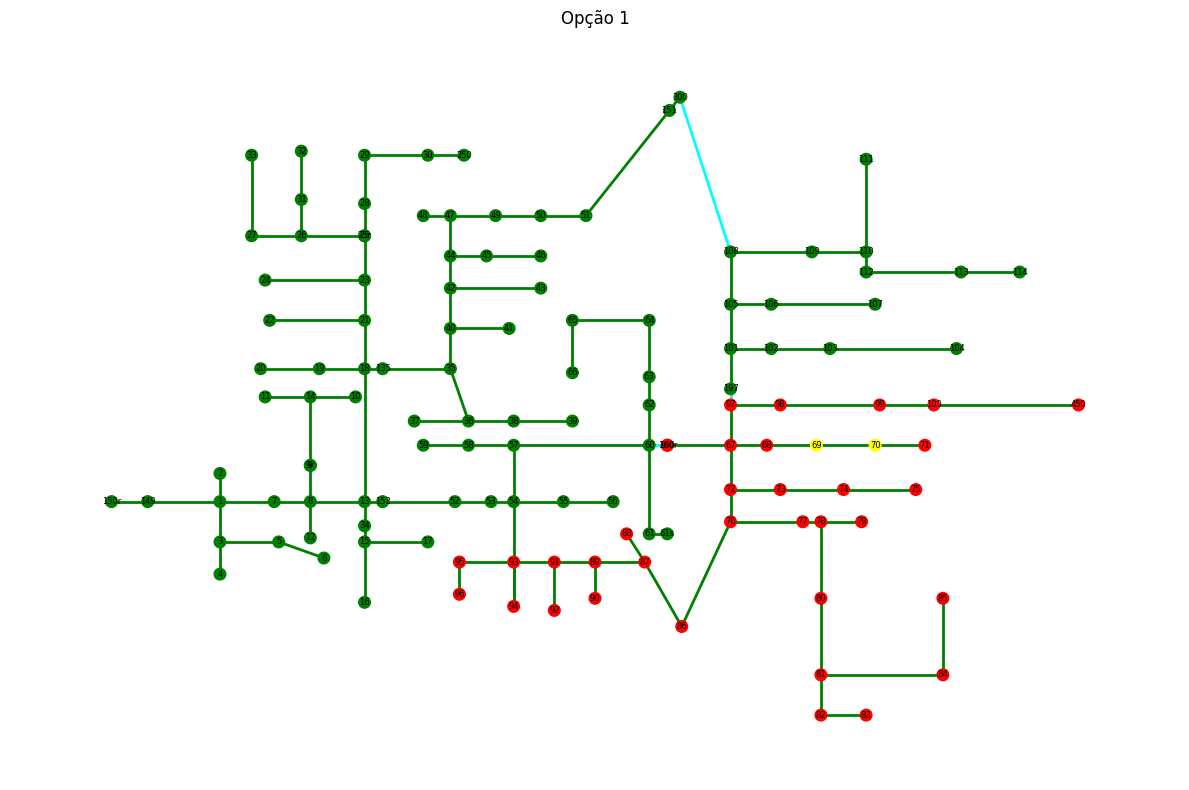


Opção 2 [BASE (NF testada)]
  NF isolação (abrir): ['line.sw4']
  NA (fechar):          -
  NF bloqueio (abrir):  -
  kW desligado:         1425.00
  Manobras:             1
  kW base:              1425.00
  ✅ Tensão: sem violações em barras energizadas (0.95–1.05 pu)


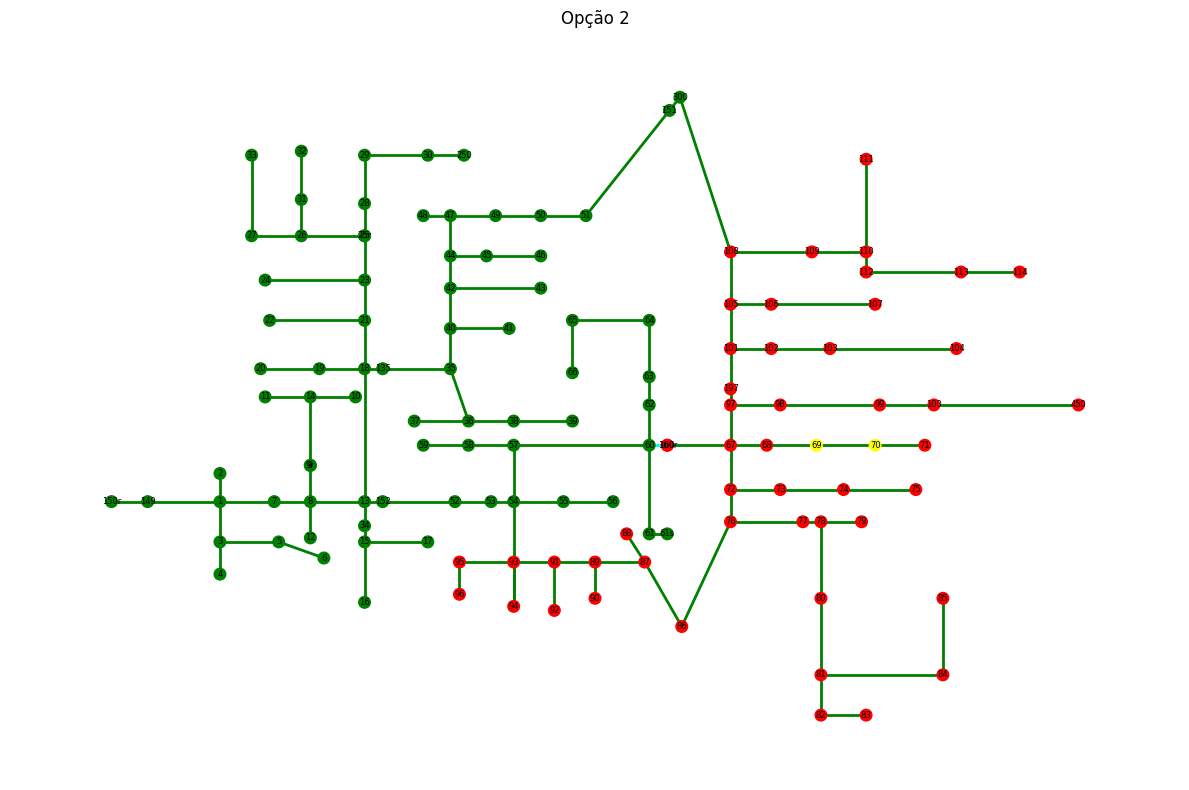


Opção 3 [NA + bloqueio]
  NF isolação (abrir): ['line.sw2']
  NA (fechar):          line.l108
  NF bloqueio (abrir):  line.sw5
  kW desligado:         1655.00
  Manobras:             3
  kW base:              1975.00
  ✅ Tensão: sem violações em barras energizadas (0.95–1.05 pu)


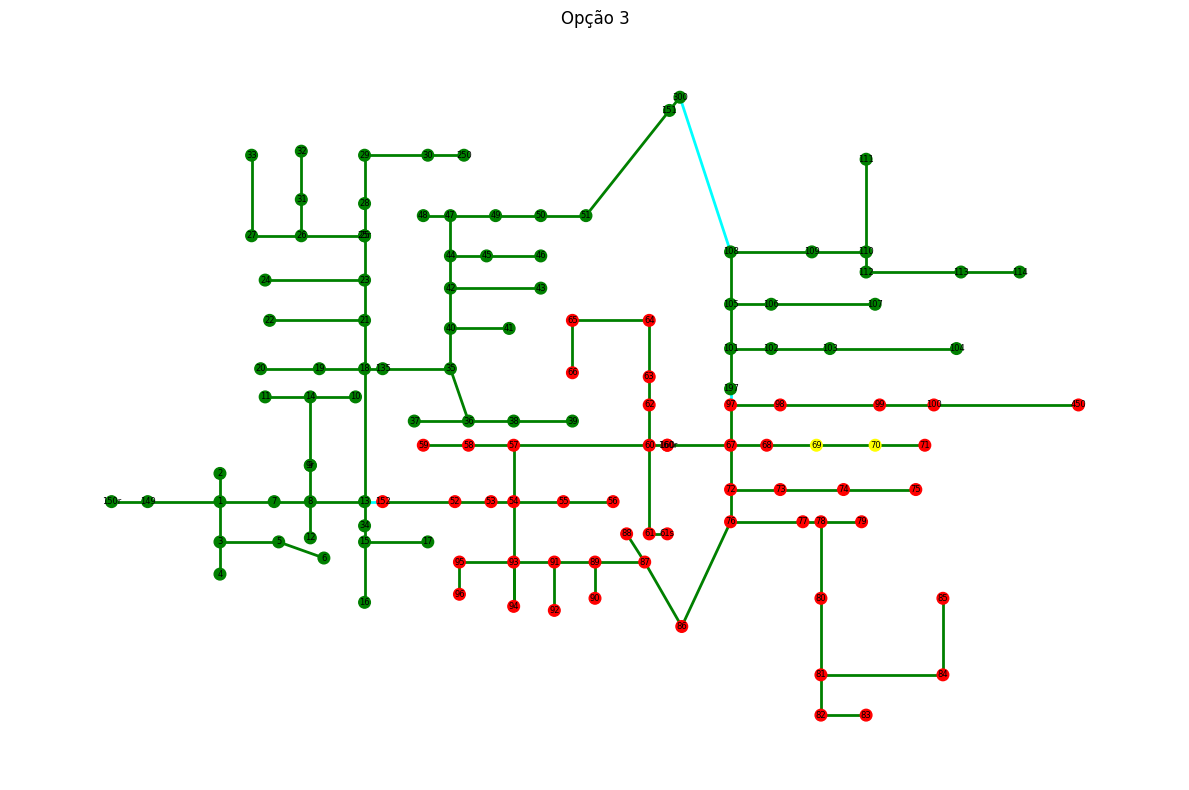

In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
#BLOCO 03 — Perdas Técnicas Totais (kW/kvar): BASE x APÓS Manobra

from typing import Dict, List, Tuple
import pandas as pd
from IPython.display import display

# 1) Utilitários: perdas e comandos

def get_total_losses_kw_kvar() -> Tuple[float, float]:
    """
    Retorna as perdas totais do circuito no estado atual (após Solve()).

    OpenDSS:
      - dss.Circuit.Losses() retorna [W, var]
    Saída:
      - (P_loss_kW, Q_loss_kvar)
    """
    p_w, q_var = dss.Circuit.Losses()  # [W, var]
    return float(p_w) / 1000.0, float(q_var) / 1000.0


def _norm_elem(elem: str) -> str:
    """Normaliza o nome do elemento para o formato 'line.xxx' (lowercase)."""
    elem = elem.strip().lower()
    return elem if elem.startswith("line.") else f"line.{elem}"


def apply_sequence_commands(seq: List[Tuple[str, str]]) -> None:
    """
    Aplica uma sequência de manobras no circuito já compilado.

    Parâmetro:
      seq = [("open","line.sw4"), ("close","line.l108"), ...]
    Regras:
      - Operações válidas: 'open' ou 'close'
      - Elementos normalizados para 'line.xxx'
    """
    for op, elem in seq:
        op = op.lower().strip()
        elem = _norm_elem(elem)

        if op not in ("open", "close"):
            raise ValueError(f"Operação inválida: {op} (use 'open' ou 'close')")

        dss.Text.Command(f"{op} {elem}")

# 2) Função principal: BASE x APÓS

def compute_losses_base_vs_after(label: str, seq: List[Tuple[str, str]]) -> Dict:
    """
    Calcula perdas ativas totais (kW) no BASE e APÓS aplicar a sequência de manobras.

    Estratégia para consistência:
      - BASE: compile_circuit() -> Solve() -> losses
      - APÓS: compile_circuit() -> aplica seq -> Solve() -> losses

    Retorno (linha de tabela):
      {"Sequência", "Perdas Base (kW)", "Perdas Após (kW)", "Δ (kW)", "Δ (%)"}
    """
    # BASE
    compile_circuit()
    dss.Solution.Solve()
    p_base_kw, _ = get_total_losses_kw_kvar()

    # APÓS
    compile_circuit()
    apply_sequence_commands(seq)
    dss.Solution.Solve()
    p_after_kw, _ = get_total_losses_kw_kvar()

    delta_kw = p_after_kw - p_base_kw
    delta_pct = (100.0 * delta_kw / p_base_kw) if p_base_kw > 0 else 0.0

    return {
        "Sequência": label,
        "Perdas Base (kW)": round(p_base_kw, 3),
        "Perdas Após (kW)": round(p_after_kw, 3),
        "Δ (kW)": round(delta_kw, 3),
        "Δ (%)": round(delta_pct, 2),
    }

# 3) Tabela consolidada

def build_losses_table(sequences: List[Tuple[str, List[Tuple[str, str]]]]) -> pd.DataFrame:
    """
    Gera um DataFrame com as perdas BASE x APÓS para uma lista de sequências.
    """
    rows = [compute_losses_base_vs_after(label, seq) for label, seq in sequences]
    df = pd.DataFrame(rows)

    # Opcional: ordenar por maior aumento de perdas
    df = df.sort_values(["Δ (kW)"], ascending=False).reset_index(drop=True)
    return df


def run_losses_for_all_maneuvers(show_table: bool = True) -> pd.DataFrame:
    """
    Execução em lote: calcula perdas para manobras típicas:
      - Aberturas únicas (sem recomposição)
      - Sequências NF–NA–NF (com recomposição + contenção)

    show_table=True:
      - exibe a tabela via display(df) (garantido no Colab)
    """
    sequences = [
        ("SW2", [("open", "line.sw2")]),
        ("SW3", [("open", "line.sw3")]),
        ("SW4", [("open", "line.sw4")]),
        ("SW5", [("open", "line.sw5")]),
        ("SW1-SW7-SW3",  [("open", "line.sw1"), ("close", "line.sw7"),  ("open", "line.sw3")]),
        ("SW1-L108-SW4", [("open", "line.sw1"), ("close", "line.l108"), ("open", "line.sw4")]),
        ("SW2-L108-SW5", [("open", "line.sw2"), ("close", "line.l108"), ("open", "line.sw5")]),
        ("SW1-L108-SW2", [("open", "line.sw1"), ("close", "line.l108"), ("open", "line.sw2")]),
        #("SW1-SW7-SW5",  [("open", "line.sw1"), ("close", "line.sw7"),  ("open", "line.sw5")]),
        ("SW4-L108-SW5", [("open", "line.sw4"), ("close", "line.l108"), ("open", "line.sw5")]),
        ("SW2-L108-SW4", [("open", "line.sw2"), ("close", "line.l108"), ("open", "line.sw4")]),
        #("SW4-SW8-SW5", [("open", "line.sw4"), ("close", "line.sw8"), ("open", "line.sw5")])
    ]

    df = build_losses_table(sequences)

    if show_table:
        print("\nPerdas técnicas totais (OpenDSS Circuit.Losses) — BASE x APÓS")
        display(df)  # <garante exibição no Colab

    return df
#Para rodar
#df_perdas = run_losses_for_all_maneuvers(show_table=True)

In [ ]:
# ================================
# BLOCO 04 — Corrente por Manobra
# ================================

from typing import List, Tuple, Dict, Set, Optional
import pandas as pd
from IPython.display import display

# --- util ---
def _norm_elem_name(elem: str) -> str:
    elem = elem.strip().lower()
    return elem if elem.startswith("line.") else f"line.{elem}"

def elem_to_lname(elem: str) -> str:
    elem = elem.strip().lower()
    return elem.split("line.")[1] if elem.startswith("line.") else elem

def get_line_imax(elem_name: str) -> float:
    elem_name = _norm_elem_name(elem_name)
    try:
        dss.Circuit.SetActiveElement(elem_name)
    except Exception:
        return 0.0
    cur = dss.CktElement.CurrentsMagAng()
    mags = cur[0::2]
    return float(max(mags)) if mags else 0.0

def get_line_norm_emerg_amps(line_name: str) -> Tuple[float, float]:
    line_name = line_name.strip().lower()
    if line_name.startswith("line."):
        line_name = line_name.split("line.")[1]
    try:
        dss.Lines.Name(line_name)
    except Exception:
        return 0.0, 0.0
    return float(dss.Lines.NormAmps()), float(dss.Lines.EmergAmps())

def is_switch_line_lname(lname: str) -> bool:
    return lname.strip().lower().startswith("sw")

# ==aplica sequência ===
def apply_sequence_commands(seq_ops: List[Tuple[str, str]]):
    """
    seq_ops: lista de tuplas (op, elem) ex.: [("open","line.sw1"), ("close","line.l108"), ...]
    """
    for op, elem in seq_ops:
        op = (op or "").strip().lower()
        elem = _norm_elem_name(elem)
        if op == "open":
            dss.Text.Command(f"open {elem}")
        elif op == "close":
            dss.Text.Command(f"close {elem}")

# --- seleção automática da linha ativa (maior I após) ---
def select_active_line_max_current(
    exclude_elems: Set[str],
    maintenance_lines: Optional[Set[str]] = None,
    imin_threshold: float = 1.0,
) -> str:
    maintenance_lines = maintenance_lines or set()
    exclude_lnames = {elem_to_lname(e) for e in exclude_elems}
    maintenance_lnames = {elem_to_lname(e) for e in maintenance_lines}

    best_elem = ""
    best_i = -1.0

    for lname in dss.Lines.AllNames():
        ln = lname.lower()
        if is_switch_line_lname(ln):
            continue
        if ln in maintenance_lnames:
            continue
        if ln in exclude_lnames:
            continue

        elem = f"line.{ln}"
        i = get_line_imax(elem)
        if i >= imin_threshold and i > best_i:
            best_i = i
            best_elem = elem

    return best_elem

# --- linha de resultado por sequência ---
def compute_current_row_for_sequence(
    label: str,
    seq_ops: List[Tuple[str, str]],
    maintenance_lines: Optional[List[str]] = None,
) -> Dict:
    maintenance_lines = maintenance_lines or []
    maintenance_set = {_norm_elem_name(x) for x in maintenance_lines}
    operated_set = {_norm_elem_name(elem) for op, elem in seq_ops}

    # Estado APÓS
    compile_circuit()
    apply_sequence_commands(seq_ops)
    dss.Solution.Solve()

    active_elem = select_active_line_max_current(
        exclude_elems=operated_set,
        maintenance_lines=maintenance_set,
        imin_threshold=1.0
    )

    if not active_elem:
        return {
            "MANOBRA": label,
            "LINHA ATIVA": "-",
            "I NOMINAL (A)": "-",
            "I EMERGÊNCIA (A)": "-",
            "I ANTES (A)": 0.0,
            "I APÓS (A)": 0.0,
            "SUPERIOR À I NOM": "NÃO",
            "SUPERIOR À I EMER": "NÃO",
            "SUPERIOR À I INICIAL": "NÃO",
            "MANOBRA VÁLIDA": "SIM",
        }

    active_lname = elem_to_lname(active_elem)
    normA, emergA = get_line_norm_emerg_amps(active_lname)

    i_after = get_line_imax(active_elem)

    # Estado BASE (mesma linha ativa)
    compile_circuit()
    dss.Solution.Solve()
    i_before = get_line_imax(active_elem)

    above_nom = (normA > 0) and (i_after > normA)
    above_emerg = (emergA > 0) and (i_after > emergA)
    above_initial = (i_after > i_before)

    created_new_nom = (normA > 0) and (i_before <= normA) and (i_after > normA)
    created_new_emerg = (emergA > 0) and (i_before <= emergA) and (i_after > emergA)

    manobra_valida = not (created_new_nom or created_new_emerg)

    return {
        "MANOBRA": label,
        "LINHA ATIVA": active_lname.upper(),
        "I NOMINAL (A)": round(normA, 2) if normA > 0 else 0.0,
        "I EMERGÊNCIA (A)": round(emergA, 2) if emergA > 0 else 0.0,
        "I ANTES (A)": round(i_before, 2),
        "I APÓS (A)": round(i_after, 2),
        "SUPERIOR À I NOM": "SIM" if above_nom else "NÃO",
        "SUPERIOR À I EMER": "SIM" if above_emerg else "NÃO",
        "SUPERIOR À I INICIAL": "SIM" if above_initial else "NÃO",
        "MANOBRA VÁLIDA": "SIM" if manobra_valida else "NÃO",
    }

def build_current_table_auto(
    sequences: List[Tuple[str, List[Tuple[str, str]]]],
    maintenance_lines: Optional[List[str]] = None,
) -> pd.DataFrame:
    maintenance_lines = maintenance_lines or []
    rows = [compute_current_row_for_sequence(label, seq_ops, maintenance_lines=maintenance_lines)
            for label, seq_ops in sequences]
    df = pd.DataFrame(rows)
    cols = [
        "MANOBRA","LINHA ATIVA","I NOMINAL (A)","I EMERGÊNCIA (A)",
        "I ANTES (A)","I APÓS (A)",
        "SUPERIOR À I NOM","SUPERIOR À I EMER","SUPERIOR À I INICIAL","MANOBRA VÁLIDA"
    ]
    return df[cols]

def run_current_table_auto(
    sequences: List[Tuple[str, List[Tuple[str, str]]]],
    maintenance_lines: Optional[List[str]] = None,
    show_table: bool = True
) -> pd.DataFrame:
    df = build_current_table_auto(sequences, maintenance_lines=maintenance_lines)
    if show_table:
        print("\nTabela de Corrente (linha ativa automática por maior I após)\n")
        display(df)
    return df

SEQUENCES_FOR_CURRENT_TABLE = [
    ("SW1-L108-SW2", [("open","line.sw1"), ("close","line.l108"), ("open","line.sw2")]),
    ("SW1-L108-SW4", [("open","line.sw1"), ("close","line.l108"), ("open","line.sw4")]),
    ("SW1-SW7-SW3",  [("open","line.sw1"), ("close","line.sw7"),  ("open","line.sw3")]),
    #("SW1-SW7-SW5",  [("open","line.sw1"), ("close","line.sw7"),  ("open","line.sw5")]),
    ("SW2",          [("open","line.sw2")]),
    ("SW2-L108-SW4", [("open","line.sw2"), ("close","line.l108"), ("open","line.sw4")]),
    ("SW2-L108-SW5", [("open","line.sw2"), ("close","line.l108"), ("open","line.sw5")]),
    ("SW3",          [("open","line.sw3")]),
    ("SW4",          [("open","line.sw4")]),
    ("SW4-L108-SW5", [("open","line.sw4"), ("close","line.l108"), ("open","line.sw5")]),
    #("SW4-SW8-SW5",  [("open","line.sw4"), ("close","line.sw8"),  ("open","line.sw5")]),
    ("SW5",          [("open","line.sw5")]),
]

# Para rodar:
#df_corrente = run_current_table_auto(SEQUENCES_FOR_CURRENT_TABLE, maintenance_lines=[], show_table=True)

In [ ]:
# BLOCO 05 - GRÁFICOS PERFIL DE TENSÃO
#  - Plota e salva um PNG por sequência em: BASE_DIR/plots_voltage_profiles/
#  - Cada gráfico: "Antes (Base)" x "Após (Manobra)" + linhas 0.95/1.05 pu

from typing import List, Tuple, Dict
import pandas as pd

PLOTS_DIR = os.path.join(BASE_DIR, "plots_voltage_profiles") #CAMINHO QUE AS IMAGENS SERÃO SALVAS
os.makedirs(PLOTS_DIR, exist_ok=True)

def get_bus_min_voltage_pu() -> Dict[str, float]:
    """MENOR tensão (pu) por barra (conservador)."""
    vpu = {}
    for bus in dss.Circuit.AllBusNames():
        dss.Circuit.SetActiveBus(bus)
        vals = dss.Bus.puVmagAngle()  # [Vpu1, ang1, Vpu2, ang2, ...]
        mags = vals[0::2]
        vpu[bus.lower()] = float(min(mags)) if mags else 0.0
    return vpu

def get_voltage_profile_dataframe(source_bus: str = BUS_FONTE_A) -> pd.DataFrame:
    """
    Ordena barras por distância topológica (nº de arestas) a partir da fonte.
    """
    G = build_graph_from_dss()
    src = source_bus.lower()
    vpu = get_bus_min_voltage_pu()

    if src not in G.nodes:
        # fallback: sem grafo (ou fonte fora do grafo)
        df = pd.DataFrame({"bus": list(vpu.keys()), "dist": 9999, "vpu": list(vpu.values())})
        df = df.sort_values(["dist", "bus"]).reset_index(drop=True)
        df["idx"] = range(len(df))
        return df

    dist = nx.single_source_shortest_path_length(G, src)
    rows = [{"bus": b, "dist": int(d), "vpu": float(vpu.get(b, 0.0))} for b, d in dist.items()]
    df = pd.DataFrame(rows).sort_values(["dist", "bus"]).reset_index(drop=True)
    df["idx"] = range(len(df))
    return df

def apply_sequence_commands(seq: List[Tuple[str, str]]):
    """
    seq: [("open","line.sw4"), ("close","line.l108"), ...]
    """
    for op, elem in seq:
        op = op.strip().lower()
        elem = elem.strip().lower()
        if not elem.startswith("line."):
            elem = f"line.{elem}"
        if op not in ("open", "close"):
            raise ValueError(f"Operação inválida: {op} (use 'open' ou 'close')")
        dss.Text.Command(f"{op} {elem}")

def plot_voltage_profile_base_vs_after(
    label: str,
    seq: List[Tuple[str, str]],
    source_bus: str = BUS_FONTE_A,
    save: bool = True,
    show: bool = False,
):
    #Plota Perfil de Tensão ao Longo da Rede (Base x Após) para uma sequência.
    # BASE
    compile_circuit()
    dss.Solution.Solve()
    df_base = get_voltage_profile_dataframe(source_bus=source_bus)
    order_buses = df_base[["bus", "dist", "idx"]].copy()

    # APÓS
    compile_circuit()
    apply_sequence_commands(seq)
    dss.Solution.Solve()
    df_after = get_voltage_profile_dataframe(source_bus=source_bus)

    # Alinha pelo conjunto do BASE (para comparar “ao longo do alimentador”)
    df = order_buses.merge(df_base[["bus", "vpu"]], on="bus", how="left")
    df = df.rename(columns={"vpu": "vpu_base"})

    df = df.merge(df_after[["bus", "vpu"]], on="bus", how="left")
    df = df.rename(columns={"vpu": "vpu_after"})

    # Barras que não aparecerem no AFTER (desconectadas do grafo) -> tensão 0.0
    df["vpu_after"] = df["vpu_after"].fillna(0.0)

    x = range(len(df))
    plt.figure(figsize=(12, 5))
    plt.plot(x, df["vpu_base"].values, label="Antes (Base)")
    plt.plot(x, df["vpu_after"].values, label="Após (Manobra)")

    plt.axhline(0.95, linestyle="--", linewidth=1)
    plt.axhline(1.05, linestyle="--", linewidth=1)

    plt.xlabel("Barras ao longo do alimentador (distância topológica)")
    plt.ylabel("Tensão mínima por barra (pu)")
    plt.title(f"Perfil de Tensão ao Longo da Rede (Base x {label})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Resumo (mínimos)
    vmin_base = float(df["vpu_base"].min())
    busmin_base = df.loc[df["vpu_base"].idxmin(), "bus"]
    vmin_after = float(df["vpu_after"].min())
    busmin_after = df.loc[df["vpu_after"].idxmin(), "bus"]

    if save:
        safe_label = (
            label.replace("–", "-").replace("—", "-")
                 .replace("/", "_").replace("\\", "_")
                 .replace(" ", "_")
        )
        out_png = os.path.join(PLOTS_DIR, f"perfil_tensao_{safe_label}.png")
        plt.savefig(out_png, dpi=200)
        print(f"Salvo: {out_png}")

    if show:
        plt.show()
    else:
        plt.close()

    print(f"{label} | Vmin(Base)={vmin_base:.4f} pu em {busmin_base} | Vmin(Após)={vmin_after:.4f} pu em {busmin_after}")

SEQUENCES_VOLT_PROFILE = [
    ("SW1-SW7-SW5",  [("open","line.sw1"), ("close","line.sw7"),  ("open","line.sw5")]),
    ("SW1-SW7-SW4",  [("open","line.sw1"), ("close","line.sw7"),  ("open","line.sw4")]),
    ("SW1-L108-SW3", [("open","line.sw1"), ("close","line.l108"), ("open","line.sw3")]),
    ("SW4-L108-SW5", [("open","line.sw4"), ("close","line.l108"), ("open","line.sw5")]),
    ("SW2-L108-SW4", [("open","line.sw2"), ("close","line.l108"), ("open","line.sw4")]),
    ("SW2-L108-SW5", [("open","line.sw2"), ("close","line.l108"), ("open","line.sw5")]),
    ("SW1-L108-SW2", [("open","line.sw1"), ("close","line.l108"), ("open","line.sw2")]),
    ("SW1-L108-SW4", [("open","line.sw1"), ("close","line.l108"), ("open","line.sw4")]),
    ("SW1-SW7-SW3",  [("open","line.sw1"), ("close","line.sw7"),  ("open","line.sw3")]),
    ("SW1", [("open","line.sw1")]),
    ("SW2", [("open","line.sw2")]),
    ("SW3", [("open","line.sw3")]),
    ("SW4", [("open","line.sw4")]),
    ("SW5", [("open","line.sw5")]),
]

# gera todos os gráficos

def run_all_voltage_profiles(save: bool = True, show: bool = False):
    print("\nGerando perfis de tensão (Base x Após) para todas as sequências...\n")
    for label, seq in SEQUENCES_VOLT_PROFILE:
        plot_voltage_profile_base_vs_after(
            label=label,
            seq=seq,
            source_bus=BUS_FONTE_A,  # ajuste se quiser BUS_FONTE_B
            save=save,
            show=show,
        )
    print(f"\nConcluído. Figuras em: {PLOTS_DIR}\n")

# Para rodar
#run_all_voltage_profiles(save=True, show=False)

In [ ]:
# BLOCO 06 — Tensão nodal (pu): Vmin e Vmax globais (BASE x APÓS)
# Objetivo:
#   - Para cada sequência de manobra, comparar os extremos de tensão do sistema:
#       Vmin_global e Vmax_global (em pu)
# Definição (global):
#   - Vmin_global = menor tensão (pu) entre todas as barras/fases consideradas
#   - Vmax_global = maior tensão (pu) entre todas as barras/fases consideradas
# Regras:
#   - BASE: considera todas as barras (inclui zeros, se existirem)
#   - APÓS: ignore_zeros=True para desconsiderar barras desligadas (V=0 pu)
#           e evitar que o Vmin seja artificialmente 0 pu.

import os
import pandas as pd

# 1) Utilitário: min/max global de tensão em pu

def get_bus_min_max_voltage_pu(ignore_zeros: bool = False, zero_eps: float = 1e-3) -> Tuple[float, float]:
    """
    Retorna (Vmin_global_pu, Vmax_global_pu) no estado atual (após Solve()).

    Parâmetros:
      ignore_zeros:
        - True: ignora tensões <= zero_eps (barras desligadas)
        - False: inclui todas as magnitudes retornadas (inclusive zeros)
      zero_eps:
        - limiar para tratar valores muito pequenos como "zero" (desligado)
    OpenDSS:
      - dss.Bus.puVmagAngle() -> [Vpu1, ang1, Vpu2, ang2, ...]
    """
    vmins = []
    vmaxs = []

    for bus in dss.Circuit.AllBusNames():
        dss.Circuit.SetActiveBus(bus)
        vals = dss.Bus.puVmagAngle()
        mags = vals[0::2]

        if not mags:
            continue

        for v in mags:
            if ignore_zeros and v <= zero_eps:
                continue
            vmins.append(v)
            vmaxs.append(v)

    if not vmins:
        # caso extremo: nenhuma barra energizada (ou tudo filtrado)
        return 0.0, 0.0

    return float(min(vmins)), float(max(vmaxs))

# 2) Função principal: BASE x APÓS por sequência

def compute_voltage_summary_for_sequence(label: str, seq: List[Tuple[str, str]]) -> Dict:
    """
    Calcula Vmin/Vmax (pu) no BASE e APÓS aplicar a sequência.

    Estratégia para consistência:
      - BASE: compile_circuit() -> Solve() -> min/max global
      - APÓS: compile_circuit() -> aplica seq -> Solve() -> min/max global
              com ignore_zeros=True (desconsidera barras desligadas)

    Retorno (linha de tabela):
      {"Sequência", "Vmin Base", "Vmax Base", "Vmin Após", "Vmax Após", "ΔVmin", "ΔVmax"}
    """
    # --- BASE ---
    compile_circuit()
    dss.Solution.Solve()
    vmin_base, vmax_base = get_bus_min_max_voltage_pu(ignore_zeros=False)

    # --- APÓS ---
    compile_circuit()
    apply_sequence_commands(seq)
    dss.Solution.Solve()
    vmin_after, vmax_after = get_bus_min_max_voltage_pu(ignore_zeros=True)

    return {
        "Sequência": label,
        "Vmin Base (pu)": round(vmin_base, 4),
        "Vmax Base (pu)": round(vmax_base, 4),
        "Vmin Após (pu)": round(vmin_after, 4),
        "Vmax Após (pu)": round(vmax_after, 4),
        "ΔVmin (pu)": round(vmin_after - vmin_base, 4),
        "ΔVmax (pu)": round(vmax_after - vmax_base, 4),
    }

# 3) Tabela consolidada

def build_voltage_summary_table(sequences: List[Tuple[str, List[Tuple[str, str]]]]) -> pd.DataFrame:
    """Gera DataFrame de Vmin/Vmax globais (BASE x APÓS) para uma lista de sequências."""
    rows = [compute_voltage_summary_for_sequence(label, seq) for label, seq in sequences]
    return pd.DataFrame(rows)


def run_voltage_summary_table(sequences: List[Tuple[str, List[Tuple[str, str]]]]) -> pd.DataFrame:
    """
    Executa a tabela de síntese de tensões e salva em CSV.
    """
    df = build_voltage_summary_table(sequences)

    print("\nTabela — Síntese de Tensões (pu) por Manobra\n")
    print(df.to_string(index=False))

# Para Exportar para CSV
    #out_csv = os.path.join(BASE_DIR, "tensoes_min_max_por_manobra.csv")
    #df.to_csv(out_csv, index=False)
    #print(f"\nCSV salvo em: {out_csv}")

    return df

#Para rodar
#df_tensoes = run_voltage_summary_table(SEQUENCES_VOLT_PROFILE)